# Pytorch入门实战（3）：使用简单CNN实现物体分类

# 本文涉及知识点
[PytorchVision Transforms的基本使用](https://blog.csdn.net/zhaohongfei_358/article/details/122799782)


[Pytorch nn.Linear的基本用法
](https://blog.csdn.net/zhaohongfei_358/article/details/122797190)

[nn.Conv2d官方文档](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)

# 本文内容

使用自己随便构造的一个简单的CNN网络，使用CIFAR10数据集（包含10种类别，图片大小为32x32）训练一个分类网络。

本文所使用到的环境如下:

```
torch==1.10.2
```

# 数据预处理

首先导入需要的包：

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np

定义transform，表明图片的处理方式和batch_size：

In [2]:
# 如果你的内存不够的话，可以减小batch_size
# 一般batch_size越大，模型越稳定，训练速度越快。（但也不是越大越好）
batch_size = 16

transform = transforms.Compose(
    [transforms.ToTensor(), # 将图片转为Tensor类型
     # 对图片进行正则化。第一个参数为mean(均值)，第二个为std(方差)。每个参数之所以有三个0.5，是因为有RGB三个通道。
     # 综上，这句就是把图片的RGB三个通道都正则化到均值为0.5，方差为0.5的分布上。
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

之后开始准备数据集，这里直接使用官方提供的数据集。如果你的网够快，可以把`download=False`改为`True`，或者通过[百度网盘](https://pan.baidu.com/s/120cx2BA2hZ2nB_qaBgekdA?pwd=6aof)下载，然后解压到`data`目录下

In [4]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False)

# CIFAR10总共10个类别
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


接下来随便打印几个看看：

In [5]:
def imshow(img):
	# 因为之前正则化了，所以显示图片前要恢复
    img = img / 2 + 0.5     # unnormalize
    # 转成Numpy.ndarray格式，plt不认tensor
    npimg = img.numpy()
    # plt.imshow接受的图片shape为(h, w, c)
    # 即通道在最后一维，而传过来的img是(c, h, w)
    # 所以要用transpose改一下
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

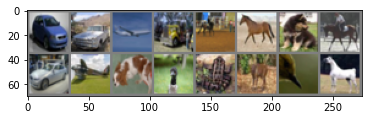

car   car   plane truck horse horse dog   horse car   plane dog   bird  frog  deer  bird  horse


In [6]:
# 获取一些图片及其对应的标签
dataiter = iter(trainloader)
"""
这里images是一个tensor，shape为(16, 3, 32, 32)
	其中16为batch_size，即16张图片，3为RGB通道，图片大小为32x32
labels也是tensor，shape为(16)，为每个图片的对应的标签。
"""
images, labels = dataiter.next()

"""
make_grid：制作表格。即把多张图片拼到一张中去。
		   nrow=8，表示生成表格的列数。
从下面的输出可以看到，images的16张图片被make_grid
按照2x8的表格拼成了一张大图片。该方法方便人们进行
图像展示。
"""
imshow(torchvision.utils.make_grid(images, nrow=8))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

# 定义CNN分类模型

In [8]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        """
      	定义卷积层, nn.Conv2d官方文档：https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
      	nn.Conv2d包含三个重要参数：
      		in_channels: 输入的通道数
      		out_channels: 输出的通道数
      		kernel_size: 卷积核的大小
      		stride: 步长，默认为1
      		padding: 填充，默认为0，即不进行填充

      	补充：这里卷积层2d的意思是数据是“2维的”，
      		  例如图片就是2维数据（长×宽）。同理也有Conv1d，
      		  是针对于文本、信号等1维数据，也有Conv3d
      		  是针对视频等这种3维数据。
      	"""
        self.classifier = nn.Sequential(
            nn.Conv2d(3, 6, 5),
            # 激活函数
            nn.ReLU(),
            # 使用MaxPool进行下采样。
            nn.MaxPool2d(2, 2),
            nn.Conv2d(6, 16, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            # 当完成卷积后，使用flatten将数据展开
            # 即将tensor的shape从(batch_size, c, h, w)变成(batch_size, c*h*w)，这样才能送给全连接层
            nn.Flatten(),
            # 最后接全连接层。
            # 计算方式可以参考：https://blog.csdn.net/zhaohongfei_358/article/details/123269313
            nn.Linear(16 * 5 * 5, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, 10)
            # 注意这里并没有调用Softmax，也不能调Softmax
            # 这是因为Softmax被包含在了CrossEntropyLoss损失函数中
            # 如果这里调用的话，就会调用两遍，最后网络啥都学不着
        )

    def forward(self, x):
        return self.classifier(x)

In [9]:
net = Net()
# 使用简单的CrossEntorpyLoss作为损失函数，一般多分类问题都用这个
criterion = nn.CrossEntropyLoss()
# 使用简单的SGD作为优化器
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# 训练网络

开始训练网络，由于网络较小，这里直接用cpu进行训练

In [10]:
# 把所有训练样本看过一遍称为1个epoch
# 简单起见，这里只训练20个epochs
epochs = 20

for epoch in range(epochs):
	# 记录一下损失
    running_loss = 0.0
    for i, data in enumerate(trainloader):
		# trainloader返回的是tuple，第一个是图片数，第二个对应的labels
        inputs, labels = data

        # 清除之前的梯度
        optimizer.zero_grad()

        # 进行前向传播
        outputs = net(inputs)
        # 计算损失
        loss = criterion(outputs, labels)
        # 反向传播
        loss.backward()
        # 更新参数
        optimizer.step()

        # 记录损失，每2000次打印一次损失
        running_loss += loss.item()
        if i % 2000 == 1999:
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.113
[2,  2000] loss: 1.567
[3,  2000] loss: 1.406
[4,  2000] loss: 1.280
[5,  2000] loss: 1.194
[6,  2000] loss: 1.121
[7,  2000] loss: 1.063
[8,  2000] loss: 1.017
[9,  2000] loss: 0.966
[10,  2000] loss: 0.924
[11,  2000] loss: 0.885
[12,  2000] loss: 0.848
[13,  2000] loss: 0.825
[14,  2000] loss: 0.787
[15,  2000] loss: 0.758
[16,  2000] loss: 0.735
[17,  2000] loss: 0.698
[18,  2000] loss: 0.679
[19,  2000] loss: 0.655
[20,  2000] loss: 0.630
Finished Training


在训练了20个epoch后，损失降到了0.648。可以看到损失还在下降，大家可以尝试多训练一段时间。

# 测试模型

测试下模型总的精准率：

In [12]:
correct = 0 # 记录正确的数量
total = 0 # 记录总数

# torch.no_grad表示不需要计算梯度。
with torch.no_grad():
    for data in testloader:
        images, labels = data
		# 前向传播
        outputs = net(images)
        """
		outputs.shape为(16, 10)，batch_size为16, 10为类别
		output这16张图片的各个类别的可能性（未经Softmax处理）
		所以通过torch.max找到最大的那个。
		torch.max接受两个参数，第一个是tensor，第二个是dim（维度）
				 这里传1，意思是在类别这个维度上取最大的
		torch.max有两个输出，values和indexes，
				 values就是最大的数是什么，
				 indexes是这些最大的数的index是什么
		这里我们只需要index即可，所以忽略第一个参数
		"""
        _, predicted = torch.max(outputs, 1)
        # 记录总数量
        total += labels.size(0)
        # 计算正确数量
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 64 %


接下来计算下每个类别精准率：

In [13]:
# 统计每个类别的正确数量和总数量
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 80.0 %
Accuracy for class: car   is 70.5 %
Accuracy for class: bird  is 53.7 %
Accuracy for class: cat   is 46.3 %
Accuracy for class: deer  is 55.6 %
Accuracy for class: dog   is 50.8 %
Accuracy for class: frog  is 77.8 %
Accuracy for class: horse is 67.4 %
Accuracy for class: ship  is 73.6 %
Accuracy for class: truck is 70.9 %


# 参考文献

[pytorch官方CNN分类样例](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html): https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html